In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import importlib as imp

import src
import trecs
from trecs.models import ContentFiltering
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement

random_state = np.random.seed(42)

In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## Analyzing Communities in MovieLens

In [3]:
ratings_df = pd.read_csv('data/ml-100k/u.data', 
                 sep="\t", 
                 names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

In [4]:
# Add 1000 to every MovieID so they don't overlap with UserID
ratings_df['MovieID'] = ratings_df['MovieID'] + 1000

In [5]:
ratings_df.sort_values('UserID').head(5)

,UserID,MovieID,Rating,Timestamp
66567,1,1055,5,875072688
62820,1,1203,4,878542231
10207,1,1183,5,875072262
9971,1,1150,5,876892196
22496,1,1068,4,875072688


MultiGraph with 2625 nodes and 100000 edges


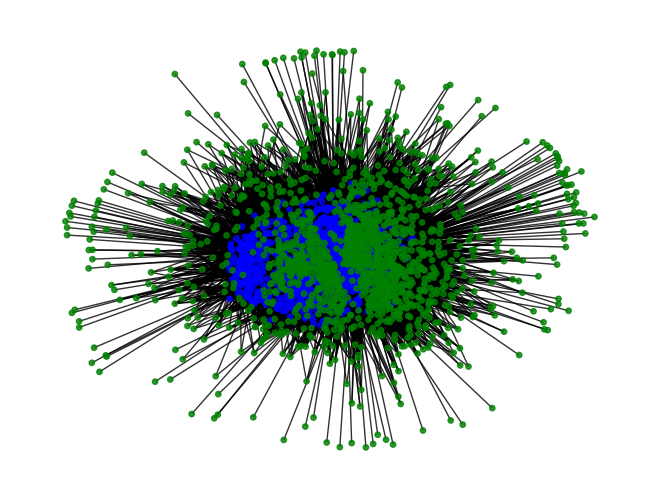

In [6]:
graph_dct = ratings_df.groupby('UserID')['MovieID'].apply(list).to_dict()

G = nx.MultiGraph(graph_dct)
print(nx.info(G))

# visualize graph
color_map = []
for node in G:
    if node < 1000:
        color_map.append('blue')
    else: 
        color_map.append('green')      


pos = nx.spring_layout(G)
nx.draw(G, node_color=color_map, node_size=15, alpha=0.8)
plt.show()

In [7]:
from community import community_louvain

comms = community_louvain.best_partition(G, resolution=2.5)

unique_coms = np.unique(list(comms.values()))
unique_coms

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76])

In [8]:
cmap = {
    0 : 'maroon',
    1 : 'teal',
    2 : 'black', 
    3 : 'orange',
    4 : 'green',
    5 : 'yellow'
}

node_cmap = [cmap[v] for _,v in comms.items()]

pos = nx.spring_layout(G)
nx.draw(G, pos, node_size = 10, alpha = 0.8, node_color=node_cmap)
plt.show()

KeyError: 52

In [ ]:
# Add comms to ratings_df as column communtyID
for i in range(len(ratings_df)):
    ratings_df.loc[i, 'communityID'] = comms[ratings_df.loc[i, 'UserID']]

In [ ]:
ratings_df.head(5)

,UserID,MovieID,Rating,Timestamp,communityID
0,196,1242,3,881250949,1.0
1,186,1302,3,891717742,31.0
2,22,1377,1,878887116,13.0
3,244,1051,2,880606923,55.0
4,166,1346,1,886397596,2.0


Text(0, 0.5, 'Number of Movies')

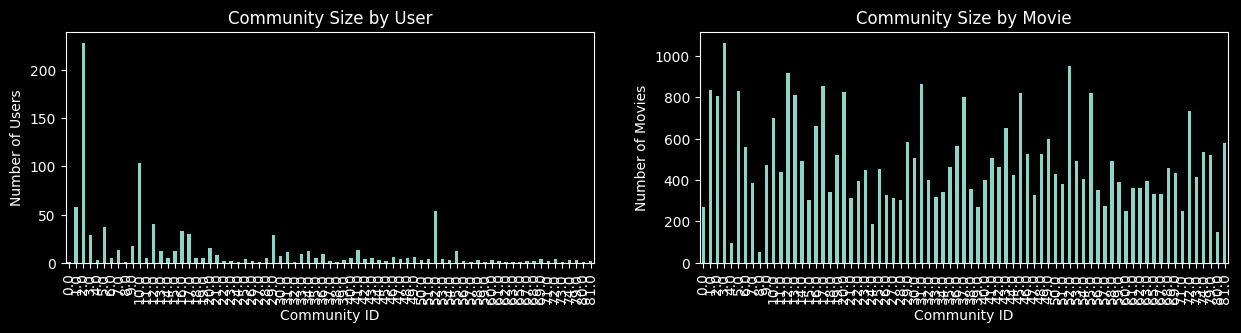

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
ratings_df.groupby('communityID')['UserID'].nunique().plot(kind='bar', ax=ax[0])
ratings_df.groupby('communityID')['MovieID'].nunique().plot(kind='bar', ax=ax[1])

ax[0].set_title('Community Size by User')
ax[0].set_xlabel('Community ID')
ax[0].set_ylabel('Number of Users')
ax[1].set_title('Community Size by Movie')
ax[1].set_xlabel('Community ID')
ax[1].set_ylabel('Number of Movies')

Text(0.5, 1.0, 'Number of reached Communities')

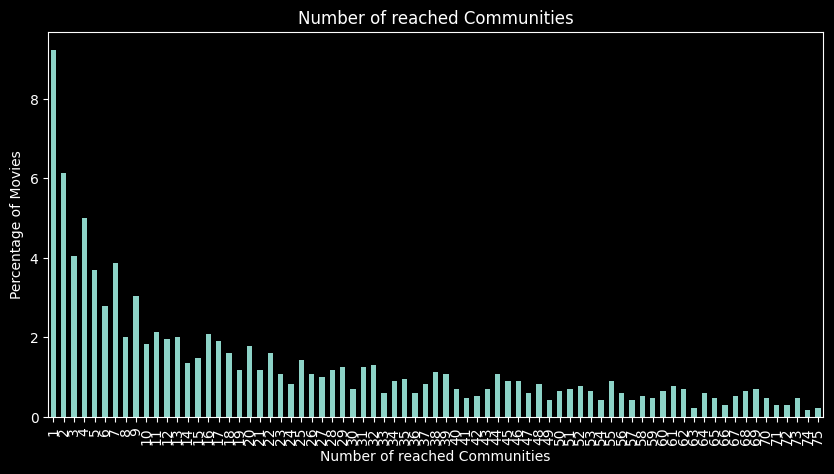

In [ ]:
num_movies = len(np.unique(ratings_df['MovieID']))
temp = ratings_df.groupby('MovieID')['communityID'].nunique().sort_values(ascending=True)
#group temp by value
temp = temp.groupby(temp.values).count()
#divide values of temp by num_movies
temp = temp/num_movies * 100
#create bar chart of temp in descending order
temp.plot(kind='bar', figsize=(10, 5))
# add axes
plt.xlabel('Number of reached Communities')
plt.ylabel('Percentage of Movies')
plt.title('Number of reached Communities')

In [ ]:
movie_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies_df = pd.read_csv('data/ml-100k/u.item', sep="|", names=movie_cols, encoding='latin')

display(movies_df.head(2))
print(movies_df.shape)

,movie_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0


(1682, 24)


In [ ]:
# join ratings_df and movies_df on movie_id
large_df = ratings_df.merge(movies_df, left_on='MovieID', right_on='movie_id')
large_df = large_df.drop(columns=['movie_id', 'release_date', 'video_release_date', 'Timestamp', 'Rating', 'title', 'IMDb_URL', 'unknown'])

large_df.head(2)
# group by communityID and sum all genre columns
genre_df = large_df.groupby('communityID').sum()
genre_df.head(5)
# for each communityID list the most common genre
# genre_df.drop(columns=['MovieID', 'UserID', 'Drama']).idxmax(axis=1)

,UserID,MovieID,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
communityID,,,,,,,,,,,,,,,,,,,,
0.0,272,309128,26,14,6,15,94,22,10,122,3,1,5,8,7,35,7,30,6,3
1.0,1387502,3651341,293,157,14,99,947,167,71,1401,26,36,31,117,80,496,67,361,74,11
2.0,3176548,8379449,382,86,10,138,2223,252,342,3232,96,151,70,223,159,1267,41,374,48,12
3.0,1226379,4783174,323,100,59,184,1106,193,146,1837,29,26,70,88,82,535,65,358,106,32
4.0,60271,127064,8,5,2,3,27,3,5,49,2,2,2,6,1,12,5,10,3,0


<AxesSubplot:xlabel='MovieID'>

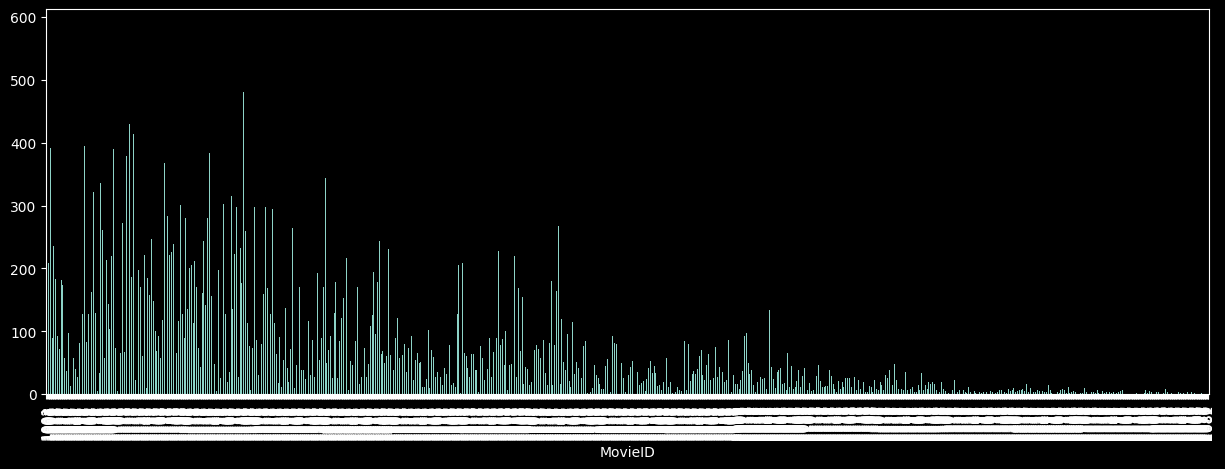

In [ ]:
# create graph of number of interactions per movie
ratings_df.groupby('MovieID')['UserID'].count().plot(kind='bar', figsize=(15, 5))